# Install Packages

In [1]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import Packages

In [2]:
from itertools import chain
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates.embeddings import AngleEmbedding
from pennylane.templates.layers import StronglyEntanglingLayers
from pennylane.optimize import GradientDescentOptimizer

# Load data

In [3]:
# load the dataset
iris = datasets . load_iris ()

# shuffle the data
X , y = shuffle ( iris . data , iris . target , random_state =0)

# select only 2 first classes from the data
X = X[y <=1]
y = y[y <=1]

# normalize data
X = minmax_scale (X , feature_range =(0 , np . pi ))

# split data into train + validation and test
X_train_val , X_test , y_train_val , y_test = train_test_split (X , y , test_size =0.2)

# Define Model

In [4]:
# number of qubits is equal to the number of features
n_qubits = X.shape[1]

# quantum device handle
dev = qml.device("default.qubit" , wires = n_qubits )

# quantum circuit
@qml.qnode(dev)
def circuit(weights,x= None):
  AngleEmbedding (x , wires = range(n_qubits))
  StronglyEntanglingLayers(weights , wires = range( n_qubits ))
  return qml.expval(qml.PauliZ(0))

# variational quantum classifier
def variational_classifier ( theta , x= None ):
  weights = theta [0]
  bias = theta [1]
  return circuit( weights , x=x) + bias

def cost ( theta , X , expectations ):
  e_predicted = np.array([ variational_classifier ( theta , x= x) for x in X ])
  loss = np.mean(( e_predicted - expectations )**2)
  return loss

In [5]:
# number of quantum layers
n_layers = 3

# split into train and validation
X_train , X_validation , y_train , y_validation = train_test_split( X_train_val , y_train_val , test_size =0.20)

# convert classes to expectations : 0 to -1, 1 to +1
e_train = np.empty_like ( y_train )
e_train[y_train == 0] = -1
e_train[y_train == 1] = +1

# select learning batch size
batch_size = 5

# calculate numbe of batches
batches = len(X_train) // batch_size

# select number of epochs
n_epochs = 5

In [6]:
# draw random quantum node weights
theta_weights = np.random.random(StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)) #strong_ent_layers_uniform ( n_layers , n_qubits , seed =42)
theta_bias = 0.0
theta_init = ( theta_weights , theta_bias ) # initial weights

# train the variational classifier
theta = theta_init


# start of main learning loop
# build the optimizer object
pennylane_opt = GradientDescentOptimizer()

# split training data into batches
X_batches = np.array_split(np .arange(len( X_train )) , batches )
for it , batch_index in enumerate ( chain (*( n_epochs * [ X_batches ]))):
  # Update the weights by one optimizer step
  batch_cost = lambda theta : cost ( theta , X_train[ batch_index ], e_train [ batch_index ])
  theta = pennylane_opt.step( batch_cost , theta )
  # use X_validation and y_validation to decide whether to stop
# end of learning loop

/usr/local/lib/python3.8/dist-packages/pennylane/_grad.py:107: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


In [10]:
# convert expectations to classes
expectations = np.array ([ variational_classifier( theta , x=x ) for x in X_test ])
prob_class_zero = ( expectations + 1.0) / 2.0
y_pred = (prob_class_zero <= 0.5)

print(metrics.accuracy_score ( y_test , y_pred ))
print(metrics.confusion_matrix ( y_test , y_pred ))

1.0
[[ 6  0]
 [ 0 14]]


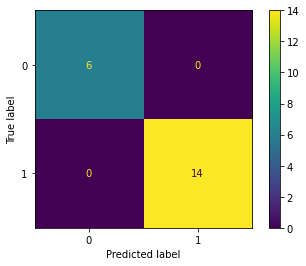

In [11]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix ( y_test , y_pred ))
disp.plot()